# 16장. 로지스틱 회귀 분석 과제

In [1]:
import matplotlib.pyplot as plt
import os
from typing import List, Tuple
import csv
from scratch.linear_algebra import Vector, get_column

## 1. 데이터셋

###  1.1 데이터셋 다운로드

In [2]:
import requests

data = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data")
dataset_path = os.path.join('data', 'wdbc.data')

with open(dataset_path, "w") as f:
  f.write(data.text)

### 1.2 데이터 파싱

In [3]:
def parse_cancer_row(row: List[str]) -> Tuple[Vector, int]:
    measurements = [float(value) for value in row[2:]]
    label = row[1]
    label = 1 if label == 'M' else 0
    return measurements, label

### 1.3 데이터 읽기
위스콘신 유방암 진단 데이터셋  (Wisconsin Breast Cancer Diagnostic dataset)
https://www.kaggle.com/uciml/breast-cancer-wisconsin-data

In [4]:
X_cancer : List[Vector] = []
y_cancer : List[int] = []
with open(dataset_path) as f:
    reader = csv.reader(f)
    for row in reader:
        x, y = parse_cancer_row(row)
        X_cancer.append(x)
        y_cancer.append(y)

In [5]:
print(X_cancer[0])
print(y_cancer[0])

[17.99, 10.38, 122.8, 1001.0, 0.1184, 0.2776, 0.3001, 0.1471, 0.2419, 0.07871, 1.095, 0.9053, 8.589, 153.4, 0.006399, 0.04904, 0.05373, 0.01587, 0.03003, 0.006193, 25.38, 17.33, 184.6, 2019.0, 0.1622, 0.6656, 0.7119, 0.2654, 0.4601, 0.1189]
1


#### 1.4 데이터 컬럼명

In [6]:
columns = [
    "radius_mean", "texture_mean", "perimeter_mean", "area_mean", "smoothness_mean", 
    "compactness_mean", "concavity_mean", "points_mean", "symmetry_mean", "dimension_mean", 
    "radius_se", "texture_se", "perimeter_se", "area_se", "smoothness_se", 
    "compactness_se", "concavity_se", "points_se", "symmetry_se", "dimension_se", 
    "radius_worst", "texture_worst", "perimeter_worst", "area_worst", "smoothness_worst", 
    "compactness_worst", "concavity_worst", "points_worst", "symmetry_worst", "dimension_worst",
    ]

## 2. 데이터 탐색

### 2.1 클래스 비율 확인

In [7]:
from collections import defaultdict
label_type = defaultdict(int)
for y in y_cancer:
    label = 'M' if y == 1 else 'B'
    label_type[label] += 1

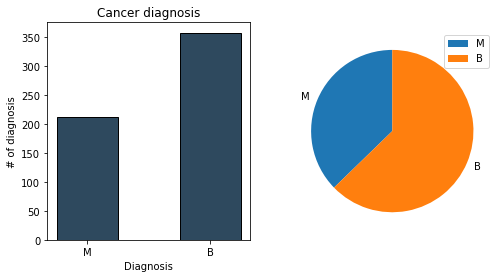

In [8]:
plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plt.bar(label_type.keys(),
        label_type.values(),
        0.5,
        facecolor="#2E495E",
        edgecolor=(0, 0, 0))                # Black edges for each bar

plt.xlabel("Diagnosis")
plt.ylabel("# of diagnosis")
plt.title("Cancer diagnosis")

plt.subplot(1, 2, 2)
pies = plt.pie(label_type.values(),
               labels=label_type.keys(),
               startangle=90)
plt.legend()
plt.show()

### 2.2 특징 별 히스토그램

In [9]:
def histogram(ax, col : int):
    
    n, bins, patches = ax.hist(get_column(X_cancer, col),
                                8,
                                facecolor="#2E495E",
                                edgecolor=(0, 0, 0)) 

    ax.set_title(columns[col], fontsize=8)

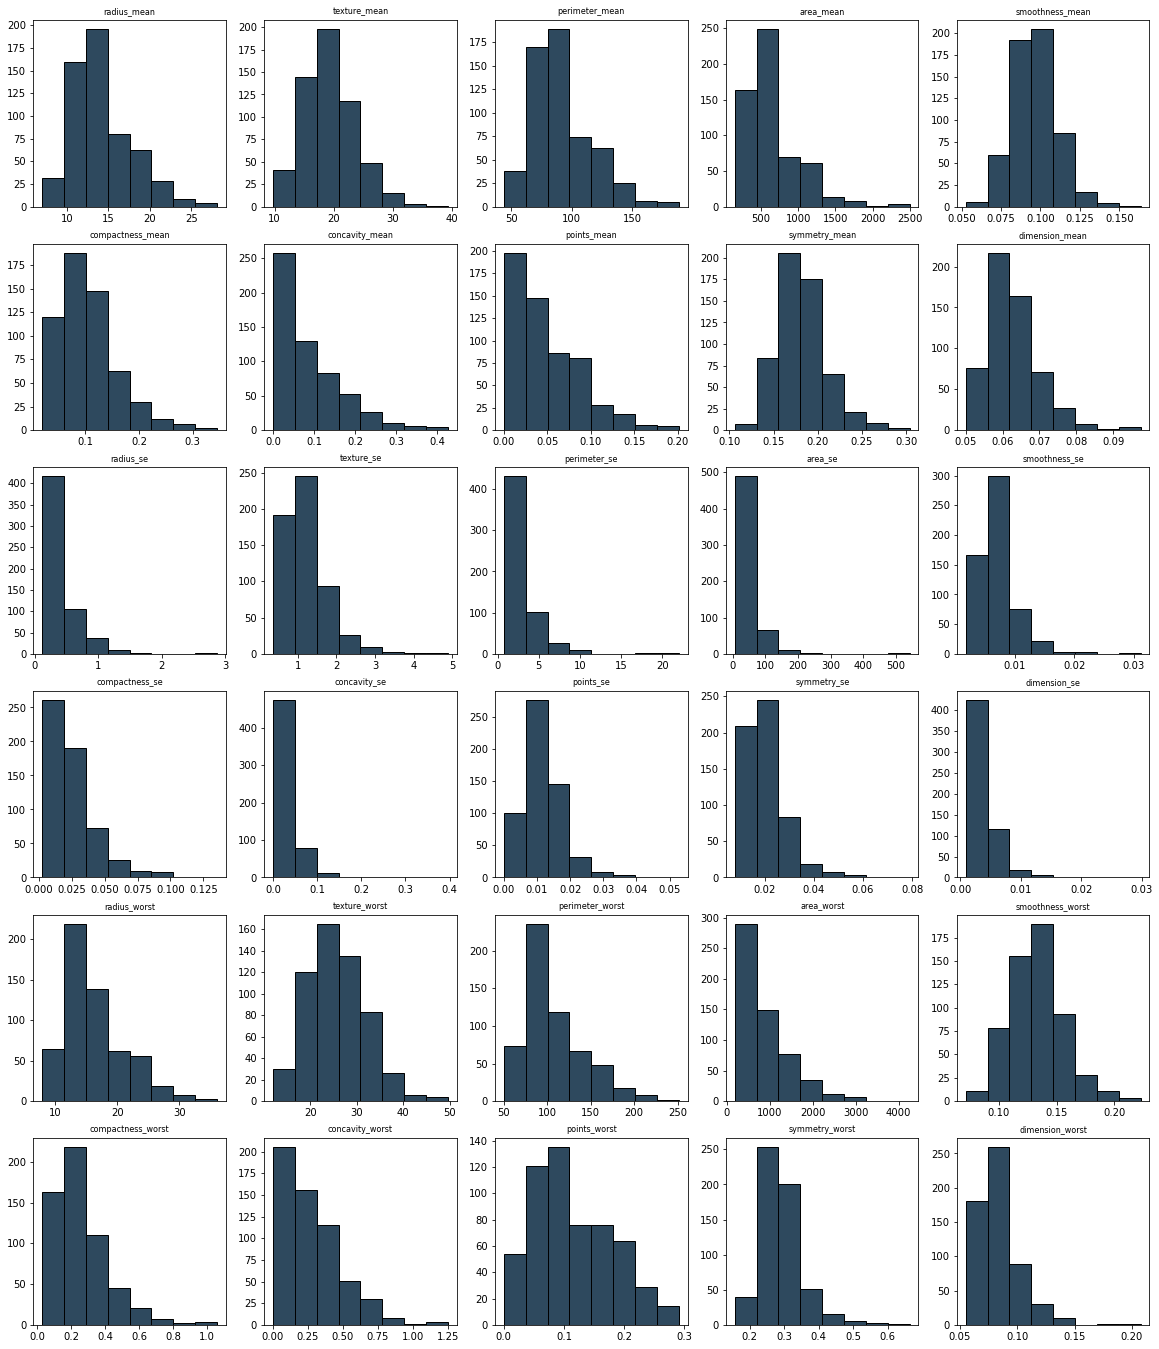

In [10]:
from matplotlib import pyplot as plt
num_rows = 6
num_cols = 5

fig, ax = plt.subplots(num_rows, num_cols, figsize=(num_cols*4, num_rows*4))
for row in range(num_rows):
    for col in range(num_cols):
        histogram(ax[row][col], num_cols * row + col)
plt.show()

### 2.3 특징 쌍 별 산포도

In [11]:
from typing import Dict
points_by_diagnosis: Dict[str, List[Vector]] = defaultdict(list)
for i, x in enumerate(X_cancer):
    y = y_cancer[i]
    label = 'M' if y == 1 else 'B'
    points_by_diagnosis[label].append(x)

In [12]:
start = 0
end = start + 10
pairs = [(i, j) for i in range(start, end) for j in range(i+1, end) if i < j]
print(pairs)
marks = ['+', '.']

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (5, 8), (5, 9), (6, 7), (6, 8), (6, 9), (7, 8), (7, 9), (8, 9)]


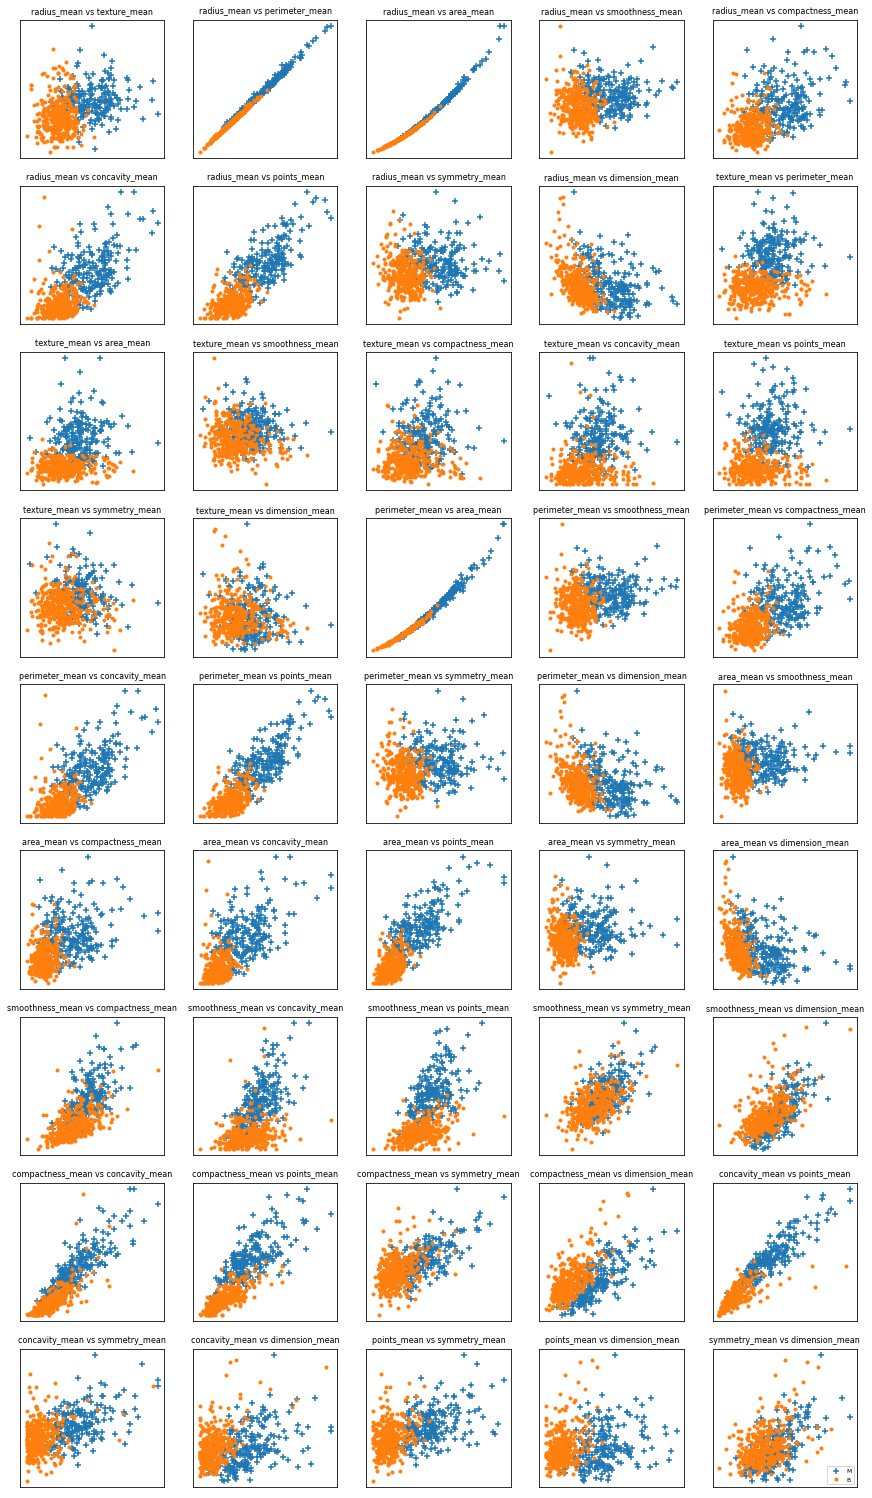

In [13]:
from matplotlib import pyplot as plt
num_rows = 9
num_cols = 5

fig, ax = plt.subplots(num_rows, num_cols, figsize=(num_cols*3, num_rows*3))


for row in range(num_rows):
    for col in range(num_cols):
        i, j = pairs[num_cols * row + col]
        ax[row][col].set_title(f"{columns[i]} vs {columns[j]}", fontsize=8)
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])

        for mark, (diagnosis, points) in zip(marks, points_by_diagnosis.items()):
            xs = [point[i] for point in points]
            ys = [point[j] for point in points]
            ax[row][col].scatter(xs, ys, marker=mark, label=diagnosis)

ax[-1][-1].legend(loc='lower right', prop={'size': 6})
plt.show()

## 3. 데이터 전처리

### 3.1 데이터셋 분리

#### 입력 데이터에 상수 항에 대한 입력 1 추가

In [14]:
X_cancer = [[1.0] + row for row in  X_cancer]

In [15]:
import random
from scratch.machine_learning import train_test_split

random.seed(12)
X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, 0.25)
print('train dataset :', len(X_train))
print('test dataset :', len(X_test))

train dataset : 426
test dataset : 143


### 3.2 데이터 표준화 (Standardization) (Q1)
훈련 데이터의 평균과 표준 편차로 테스트 데이터를 표준화 하도록 normalization() 함수를 작성해 보시오.

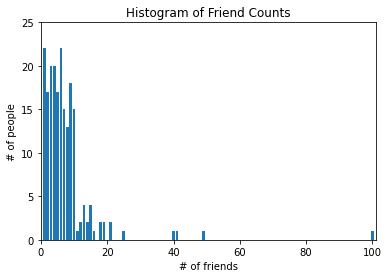

In [16]:
from scratch.working_with_data import scale, rescale
from __future__ import annotations
from typing import List
def normalization(data: List[Vector],
                  means : Vector = None,
                  stdevs : Vector = None) -> List[Vector]:
    dim = len(data[0]) # [0] 부분인 id의 총개수를 dim변수에 저장
    means, stdevs = scale(data) # data를 scale함수로 평균과 표준편차 구함
    rescaled = [v[:] for v in data]  #  rescaled 변수에 데이터를 리스트화 
    for v in rescaled:
        for i in range(dim):
            if stdevs[i] > 0:
                v[i] = (v[i] - means[i]) / stdevs[i]   # data를 미리 구한 평균과 표준 편차로 표준화 시킴 

    return rescaled, means, stdevs

In [17]:
X_train_normed, X_train_means, X_train_stdevs = normalization(X_train)
X_test_normed, _, _  = normalization(X_test, X_train_means, X_train_stdevs)

## 4. 로지스틱 회귀

### 4.1 로지스틱 함수 (Logistic Function) (Q2)
로지스틱 함수와 미분을 구현해 보시오.

In [18]:
from matplotlib import pyplot as plt

def logistic(x: float) -> float:
    return 1.0 / (1 + math.exp(-x))

def logistic_prime(x: float) -> float:
    y = logistic(x)
    return y * (1 - y)

### 4.2 손실 함수 (Q3)
베르누이 분포의 음의 로그 우도(NLL)로 정의되는 손실 함수를 구현해 보시오.

In [19]:
import math
from scratch.linear_algebra import Vector, dot
def _negative_log_likelihood(x: Vector, y: float, beta: Vector) -> float:
    if y == 1:
        return -math.log(logistic(dot(x, beta)))
    else:
        return -math.log(1 - logistic(dot(x, beta)))

from typing import List
def negative_log_likelihood(xs: List[Vector],
                            ys: List[float],
                            beta: Vector) -> float:
    return sum(_negative_log_likelihood(x, y, beta)
                for x, y in zip(xs, ys))

### 4.3 손실 함수 미분 (Q4)
NLL의 그래디언트를 구현해 보시오.

In [20]:
from scratch.linear_algebra import vector_sum
def _negative_log_partial_j(x: Vector, y: float, beta: Vector, j: int) -> float:
    return -(y - logistic(dot(x, beta))) * x[j]

def _negative_log_gradient(x: Vector, y: float, beta: Vector) -> Vector:
    return [_negative_log_partial_j(x, y, beta, j)
                for j in range(len(beta))]
def negative_log_gradient(xs: List[Vector],
                            ys: List[float],
                            beta: Vector) -> Vector:
    return vector_sum([_negative_log_gradient(x, y, beta)
                    for x, y in zip(xs, ys)])

### 4.4 모델 훈련 (Q5)
로지스틱 회귀 모델 학습을 경사 하강법으로 구현하시오.

In [21]:
import random
import tqdm
import IPython.display as display
from scratch.linear_algebra import vector_mean
from scratch.gradient_descent import gradient_step

def logistic_regression(xs: List[Vector],
                        ys: List[float],
                        learning_rate: float = 0.001,
                        num_steps: int = 1000,
                        batch_size: int = 1) -> Vector:
    print(len(xs[0]))
    print(len(ys))
    history = []
    random_rate = 0.01
    beta = [random.random() for _ in range(31) ]   #  30 개 파라미터
    with tqdm.trange(num_steps) as t:
        for epoch in t:
            gradient = negative_log_gradient(xs, ys, beta)
            beta = gradient_step(beta, gradient, -learning_rate)
            loss = negative_log_likelihood(xs, ys, beta)
            t.set_description(f"loss: {loss:.3f} beta: {beta}")
            history.append(loss)
    return beta, history

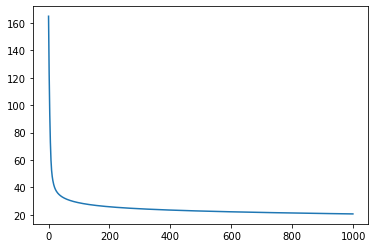

In [22]:
beta, loss = logistic_regression(X_train_normed, y_train)
import IPython.display as display
history = []
history += loss   # history에 위에서 구한 loss값을 계속 추가함.
epoch = 100
if epoch and epoch % 100 == 0:
    display.clear_output(wait=True)
    plt.plot(history)
    plt.show()

#### 𝜷 확인

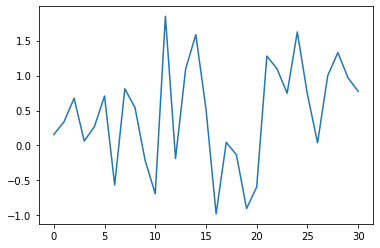

In [23]:
plt.plot(beta)
plt.show()

### 3.7 모델 테스트 (Q6)
테스트 데이터를 이용해서 모델 예측을 해보고 TP, FP, FN, TN을 계산해 보시오.

In [24]:
i = 0 
TP = FP = TN = FN = 0
prediction = 0.0
for x_i, y_i in zip(X_test, y_test):
    prediction = [logistic(dot(beta, x)) for x in X_test_normed]
    
    if y_i == 1 and prediction[i] >= 0.5: # TP: paid and we predict paid
        TP += 1
    elif y_i == 1: # FN: paid and we predict unpaid
        FN += 1
    elif prediction[i] >= 0.5: # FP: unpaid and we predict paid
        FP += 1
    else: # TN: unpaid and we predict unpaid
        TN += 1
    i +=1
confusion_matrix = [[TP, FP], [FN, TN]]
print(confusion_matrix)

[[49, 3], [2, 89]]


### 3.8 모델 성능

In [25]:
from scratch.machine_learning import accuracy, precision, recall, f1_score

print(confusion_matrix)
print("accuracy :", accuracy(TP, FP, FN, TN))
print("precision :", precision(TP, FP, FN, TN))
print("recall :", recall(TP, FP, FN, TN))
print("f1_score :", f1_score(TP, FP, FN, TN))

[[49, 3], [2, 89]]
accuracy : 0.965034965034965
precision : 0.9423076923076923
recall : 0.9607843137254902
f1_score : 0.9514563106796117


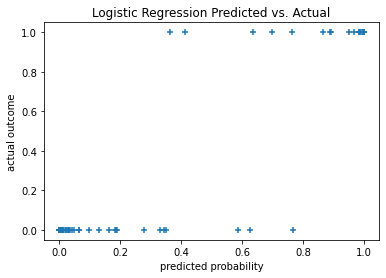

In [26]:
predictions = [logistic(dot(beta, x)) for x in X_test_normed]
# print(predictions)
plt.scatter(predictions, y_test, marker='+')
plt.xlabel("predicted probability")
plt.ylabel("actual outcome")
plt.title("Logistic Regression Predicted vs. Actual")
plt.show()